In [1]:
import sys
import rospy
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

sys.path.insert(0, '/home/lucas/Documents/EESC_Linux/Drone_project/sarc/SARC2022/python/uav')

from uav import UAV
from sensors.gps import uavGPS
from sensors.camera import uavCamera

In [2]:
df = pd.read_csv('./Positions.csv')
df = df.drop('foo', axis = 1)
df.head()

time         x         y         z
0     0 -0.115169 -0.117995  1.677085
1     1 -0.113119 -0.120490  1.676861
2     2 -0.112885 -0.123462  1.668329
3     3 -0.114845 -0.112779  1.664539
4     4 -0.107017 -0.126723  1.653362

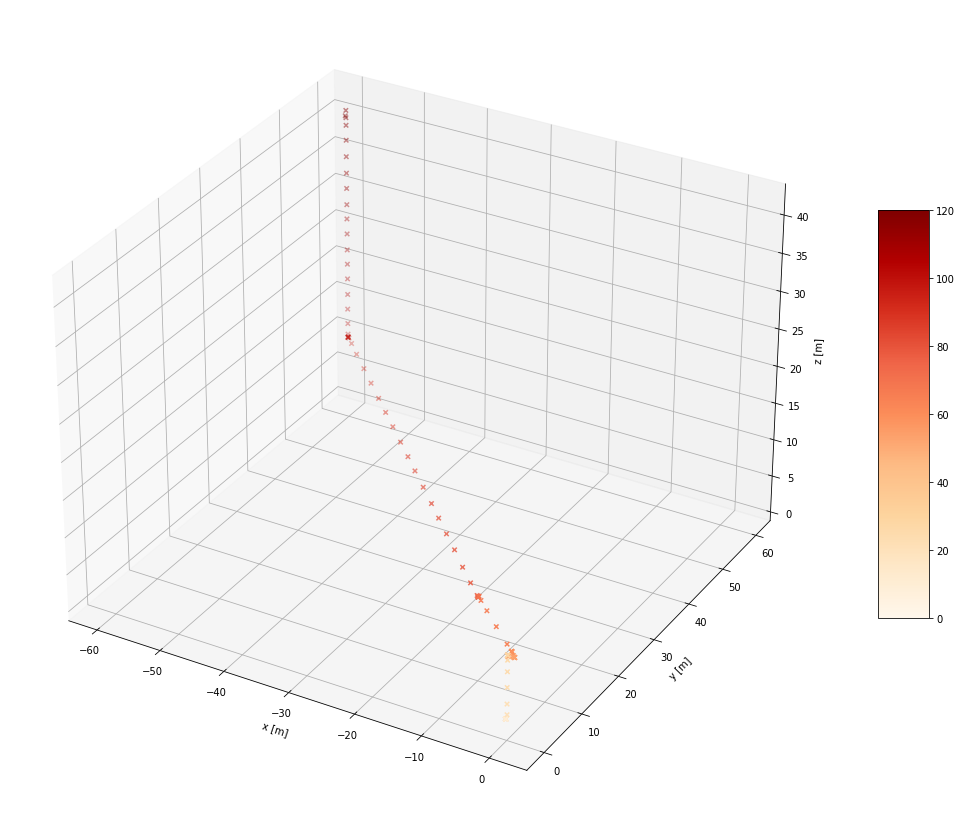

In [3]:
fig = plt.figure(figsize=(20,15))

ax = fig.add_subplot(111, projection='3d')
pts = ax.scatter(df['x'], df['y'], df['z'], c = df['time'], cmap='OrRd', marker='x')

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')

fig.colorbar(pts ,shrink=0.5, aspect=8)
plt.show()

In [4]:
# 3D Grid space
grid_space = np.linspace(-2500,2500, 5000)


In [5]:
#BGR -> RGB
def to_rgb(cv_img):
    rgb_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    return rgb_img

def img_show(img, title = None):
    
    plt.figure(figsize=(20,15))
    if title is not None:
        plt.title(title)

    plt.imshow(to_rgb(img))

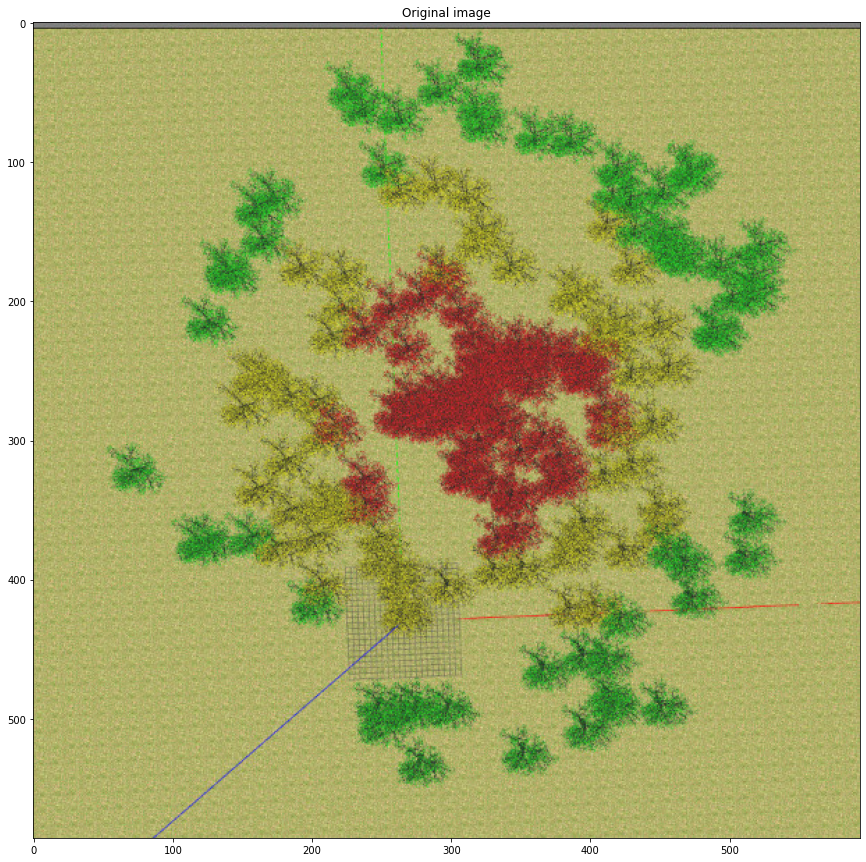

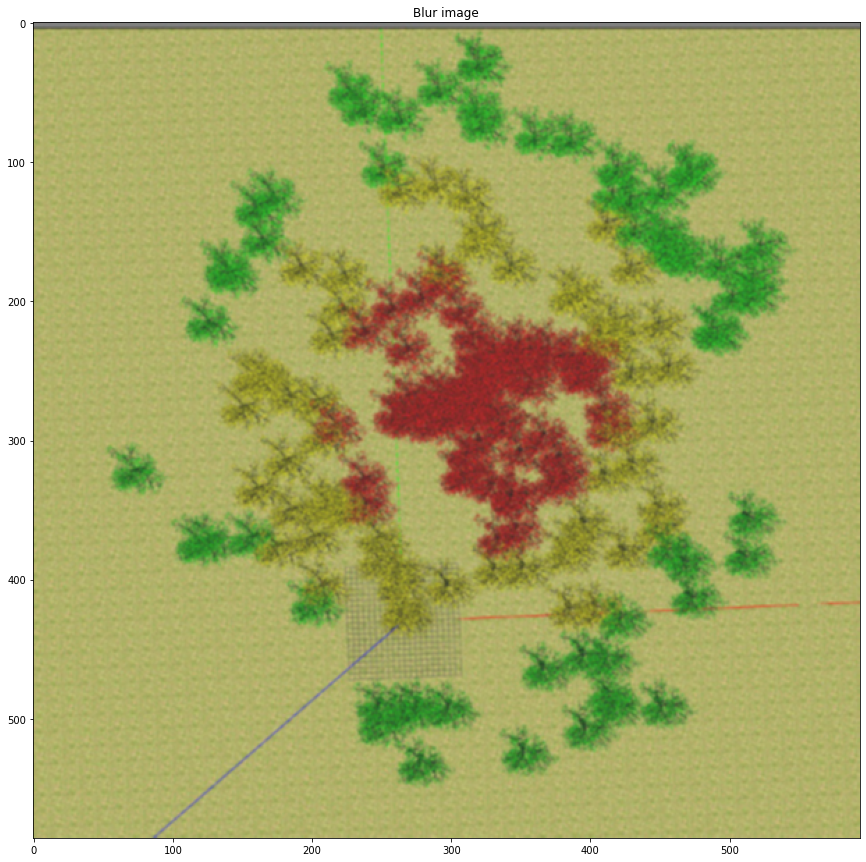

In [6]:
img_cv = cv2.imread('./scene_01.jpeg')

kernel = np.ones((5,5), dtype = np.float32)

img_blur = cv2.GaussianBlur(img_cv, (3,3), 0)

img_show(img_cv, "Original image")
img_show(img_blur, "Blur image")

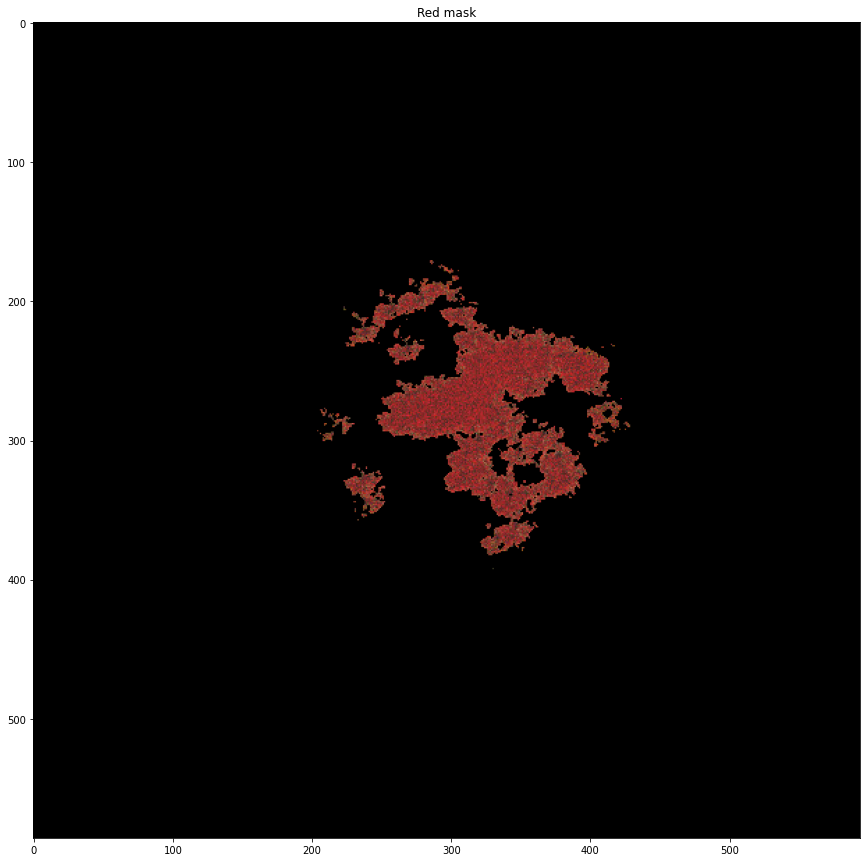

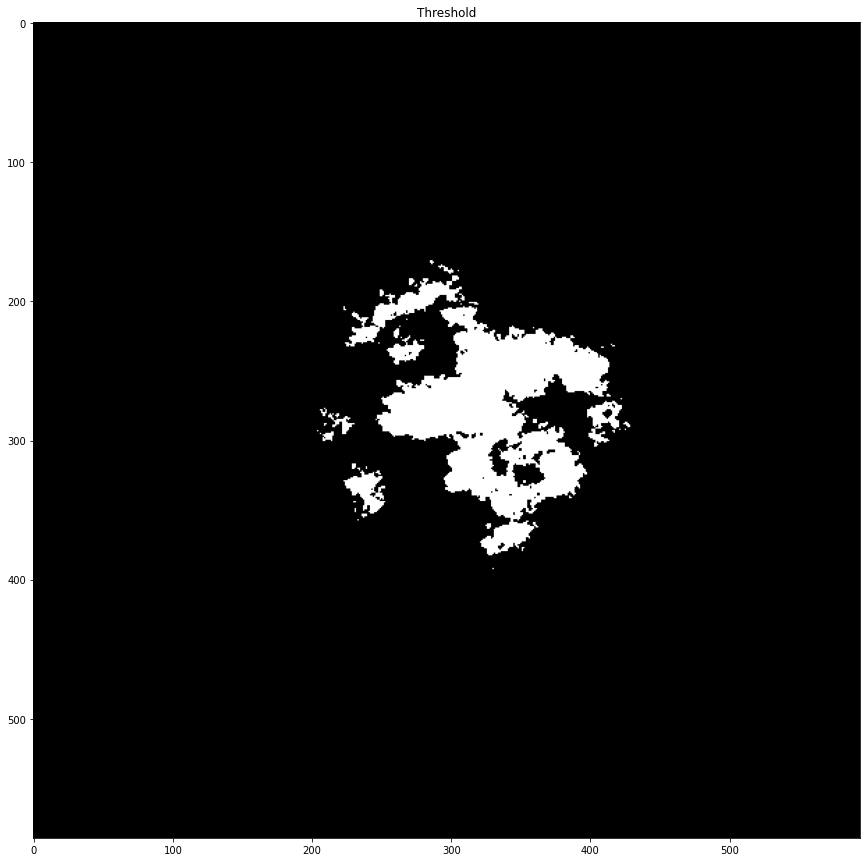

In [7]:
red_mask = cv2.inRange(img_blur, (0, 0, 80), (255, 80, 255))
result_red = cv2.bitwise_and(img_cv, img_cv, mask=red_mask)

img_show(result_red, title="Red mask")
img_show(red_mask, title="Threshold")

15501.5


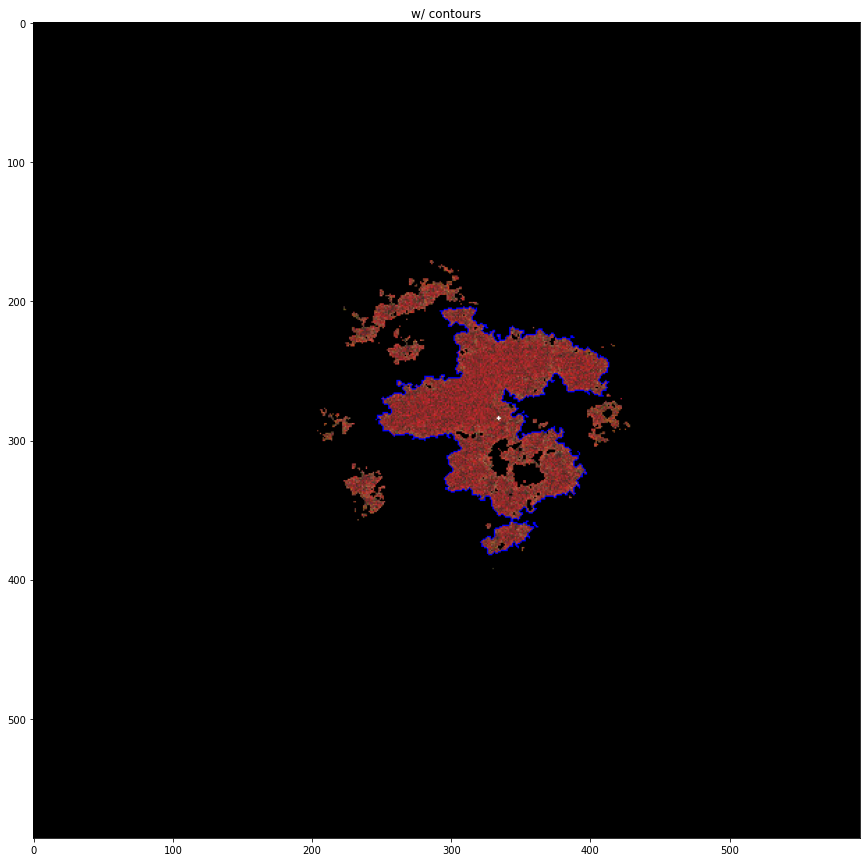

In [8]:
contours, _ = cv2.findContours(red_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
img_temp = np.copy(result_red)
# cv2.drawContours(red_mask, contours)

big_contour = list()
x_centers = list()
y_centers = list()
total_area = 0

for contour in contours:
    area = cv2.contourArea(contour)
    total_area += area
    if area > 1000 :
        big_contour.append(contour)
        
        cv2.drawContours(img_temp, contour, -1, (255,0,0), 1)
        M = cv2.moments(contour)
            #Centroid
        cx = int(M["m10"]/M["m00"])
        cy = int(M["m01"]/M["m00"])

        x_centers.append(cx)
        y_centers.append(cy)
        
        #Criando um ponto para representar o centroid
        cv2.circle(img_temp, (cx,cy), 1, (255, 255, 255), -1)
        
        ### contour_scaled = scale_factor * (original_contour - center) + center
        
        # contour_scaled = 1.2*(contour - np.array([cx, cy]))
        # contour_scaled = contour_scaled.astype('int') + np.array([cx, cy])

        # cv2.drawContours(img_temp, contour_scaled, -1, (255,255,255), 1)
        
            
img_show(img_temp, "w/ contours")
print(total_area)

Quadrado que contém o vermelho detectado

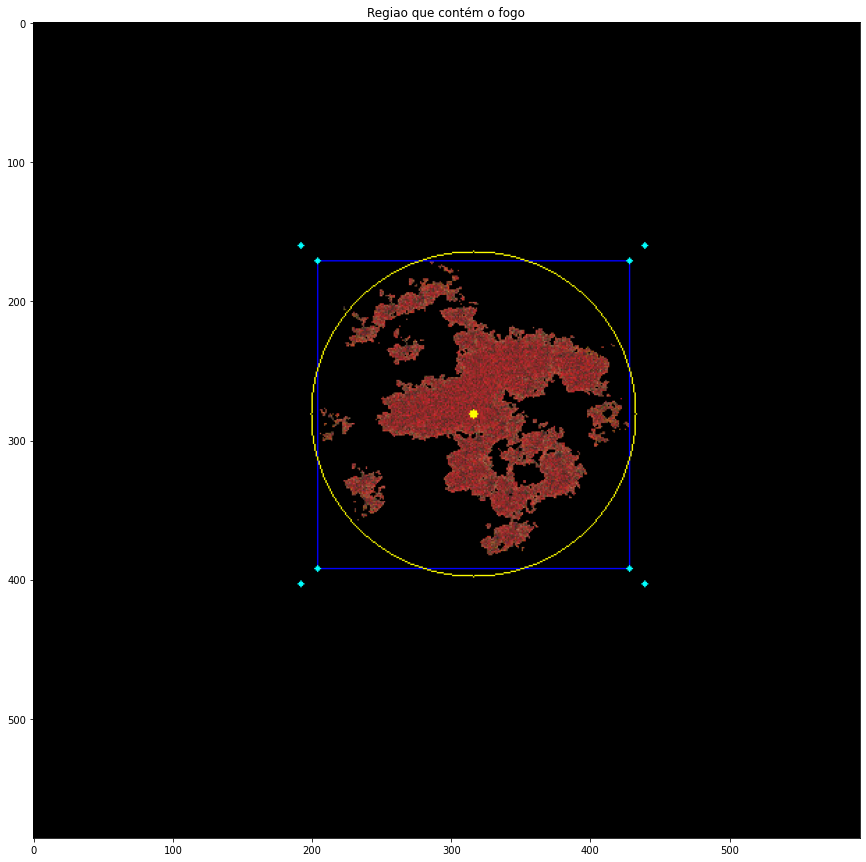

In [9]:
x_reds, y_reds = np.nonzero(red_mask)[1], np.nonzero(red_mask)[0]

img_temp = np.copy(result_red)

xmin, xmax = min(x_reds), max(x_reds)
ymin, ymax = min(y_reds), max(y_reds)

x_center = int(0.5*(xmin + xmax))
y_center = int(0.5*(ymin + ymax))

box = cv2.rectangle(img_temp, (xmin, ymin), (xmax,ymax), (255,0,0),1)


#Vertices
cv2.circle(img_temp, (xmin,ymin), 2, (255, 255, 0), -1)
cv2.circle(img_temp, (xmax,ymax), 2, (255, 255, 0), -1)
cv2.circle(img_temp, (xmax,ymin), 2, (255, 255, 0), -1)
cv2.circle(img_temp, (xmin,ymax), 2, (255, 255, 0), -1)
#Centro
cv2.circle(img_temp, (x_center,y_center), 3, (0, 255, 255), -1)

#TODO: Utilizar essa funcao para mudar a escala da trajetoria
scale = 1.1
xmin_scaled = int(scale*(xmin - x_center) + x_center)
xmax_scaled = int(scale*(xmax - x_center) + x_center)
ymin_scaled = int(scale*(ymin - y_center) + y_center)
ymax_scaled = int(scale*(ymax - y_center) + y_center)

cv2.circle(img_temp, (xmin_scaled, ymin_scaled), 2, (255, 255, 0), -1)
cv2.circle(img_temp, (xmax_scaled,ymax_scaled), 2, (255, 255, 0), -1)
cv2.circle(img_temp, (xmax_scaled,ymin_scaled), 2, (255, 255, 0), -1)
cv2.circle(img_temp, (xmin_scaled,ymax_scaled), 2, (255, 255, 0), -1)

#scale factor de 1.05
raio = int(1.05 * 0.5*max((xmax-xmin), (ymax-ymin)))

circ = cv2.circle(img_temp, (x_center, y_center), raio, (0,255,255), 1)
img_show(img_temp, title = "Regiao que contém o fogo")

https://mayavan95.medium.com/3d-position-estimation-of-a-known-object-using-a-single-camera-7a82b37b326b

Calculate 3D position

\begin{equation*}
    Z = L \frac{f_x}{d_{pix}}
\end{equation*}

\begin{equation*}
    X = \frac{Z(x - c_x)}{f_x}
\end{equation*}

\begin{equation*}
    Y = \frac{Z(y - c_y)}{f_y}
\end{equation*}

In [10]:
height = red_mask.shape[0]
width = red_mask.shape[1]

cx = int(0.5*width)
cy = int(0.5*height)

def real_position(  x, y,
                    fx, fy,
                    cx: int, cy:int,
                    L = 20):
    
    # Z = L * fx/dpix
    Z = 100 #altura em metros
    X = Z * (x - cx)/fx
    Y = Z * (y - cy)/fy
    return X, Y

In [11]:
#(xmin, ymin)
xmin_real, ymin_real = real_position(   x = xmax, y = ymax,
                                        fx = 277, fy = 277,
                                        cx = x_center, cy = y_center)            

x_real, y_real = real_position(   x = x_reds, y = y_reds,
                                        fx = 277, fy = 277,
                                        cx = x_center, cy = y_center)            

In [12]:
big_contour[0]
x_contour = []
y_contour = []

for pt in big_contour[0]:
    
    x_contour.append(pt[0][0])
    y_contour.append(pt[0][1])


[]

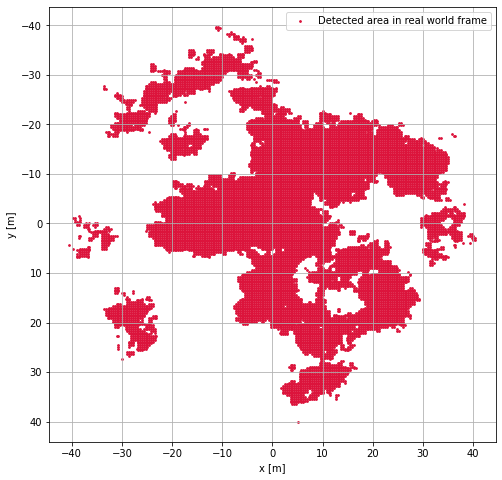

In [13]:
plt.figure(figsize = (8,8))

plt.gca().invert_yaxis()
plt.scatter(x_real, y_real, label='Detected area in real world frame', s = 3, color='crimson')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.grid()
plt.legend()
plt.plot()

NameError: name 'gps' is not defined

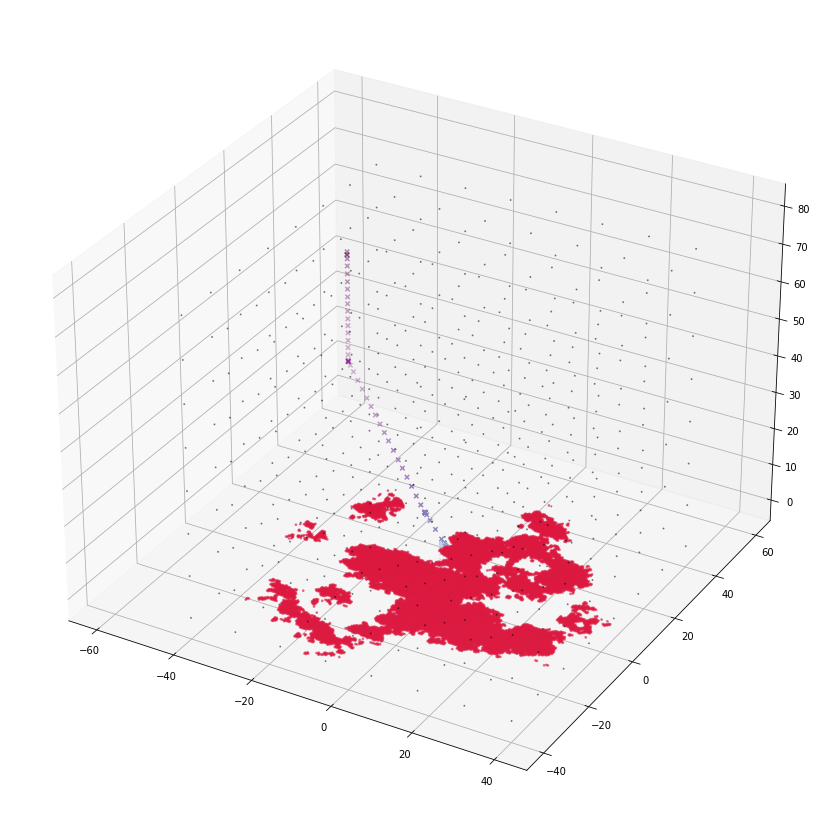

In [14]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='3d')

#3D Grid
space_1d = np.linspace(-40, 40, 8)
grid = np.meshgrid(space_1d, space_1d, np.linspace(0, 80, 8))
pts = ax.scatter(grid[0], grid[1], grid[2], c='black', alpha=0.4, s =1, label = "Grid")

#UAV trajectory
uav_pos = ax.scatter(df['x'], df['y'], df['z'], c = df['time'],
                    cmap='BuPu', marker='x', label = "UAV Trajectory")

#Fire detected
pts_fire = ax.scatter(  x_real, y_real, np.zeros_like(x_real),
                        c='crimson', s = 3, alpha=0.5, label = "Pontos fogo")

#Bounding box vertices
xbox = np.array([xmin, xmin, xmax, xmax])
ybox = np.array([ymin, ymax, ymin, ymax])

fx = 277.0
fy = 277.0
    
xbox_real, ybox_real = real_position(   x = xbox, y = ybox,
                                        fx = fx, fy = fy,
                                        cx = x_center, cy = y_center)
rx = int(1.05 * 0.5 * (max(xbox_real) - min(xbox_real)))
ry = int(1.05 * 0.5 * (max(ybox_real) - min(ybox_real)))

raio_real = max(rx, ry)

#Pontos da trajetoria circular
xs_circ_trajectory, ys_circ_trajectory = gps.circular_trajectory_pts(   x_center = 0.0,
                                                                        y_center = 0.0,
                                                                        radius = raio_real,
                                                                        num_of_pts = 12)


# pts_box = ax.scatter(xbox_real, ybox_real, np.zeros_like(xbox_real),
#                     c='black', marker = 's', label = f"Pontos extremidades. fx = {fx}")

ax.scatter(xs_circ_trajectory, ys_circ_trajectory, np.zeros_like(xs_circ_trajectory),
            c = 'black', label = 'Trajectory points')
    
plt.title("Teste para verificar ordem de grandeza da área detectada")
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
plt.legend()
plt.show()

Testando as funçoes do GPS

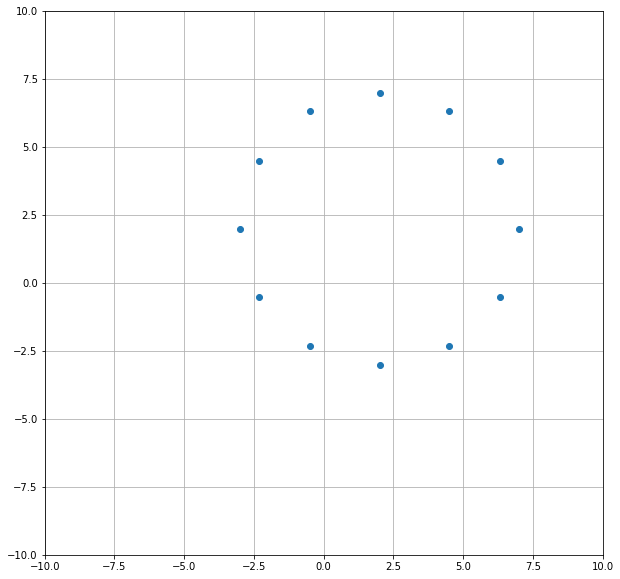

In [ ]:
gps = uavGPS(node_name='meu_gps', subscriber_name = 'meu_gps')

angles = 30 * np.array([i for i in range(12)])
xs_circ, ys_circ = gps.circle_equation( angle_deg = angles,
                                        x_center = 2.0,
                                        y_center = 2.0,
                                        radius = 5.0)

plt.figure(figsize = (10,10))
plt.scatter(xs_circ, ys_circ)
plt.grid()
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.show()                                        

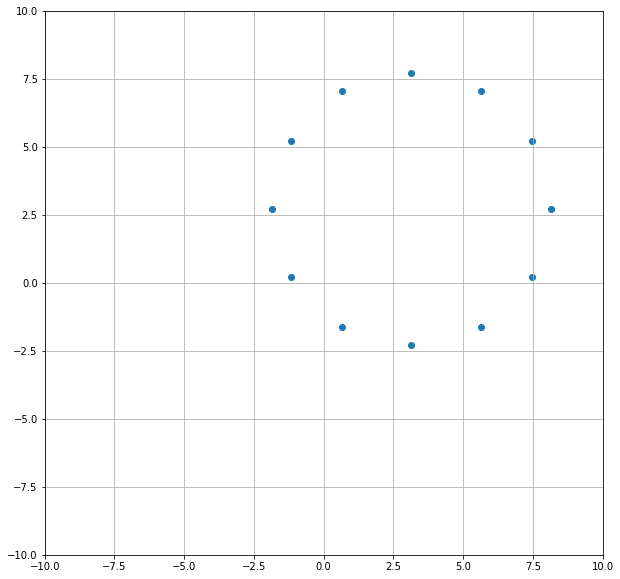

In [ ]:
xs_circ_trajectory, ys_circ_trajectory = gps.circular_trajectory_pts(   x_center = np.pi,
                                                                        y_center = np.e,
                                                                        radius = 5.0,
                                                                        num_of_pts = 12)


plt.figure(figsize = (10,10))
plt.scatter(xs_circ_trajectory, ys_circ_trajectory)
plt.grid()
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.show()                                                                               